## Introduction

This notebook is meant to guide you with few introductory steps with MNE in order to help you start you future analyses !

Overall this notebook will address :

    1. Importing data
    2. Using a montage from MNE Built-ins and adding it to the data
    3. Visualize the previously cleaned data
    4. Segmentation of continuous data
    5. Plotting of PSD and topomaps
    
*This markdown is organized by a table of content which is one of many [extensions](http://localhost:8888/nbextensions/?nbextension=toc2/main) you can get for jupyter notebook following this github [page](https://github.com/ipython-contrib/jupyter_contrib_nbextensions). Installing these prior to consulting this document will help with the flow of the documentation.*

First step is always to import the needed modules

In [18]:
%matplotlib inline # if you want to see the interactive outputs use %matplotlib qt instead
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import mne
import pytest
from mne import channels
from mne import io, read_proj, read_selection
from mne.datasets import sample
from mne.time_frequency import tfr_morlet
from mne.time_frequency import psd_welch
from mne.time_frequency import psd_multitaper
from mne.channels.montage import get_builtin_montages
from ipywidgets import interact, interactive, fixed, interact_manual
print(__doc__)

Automatically created module for IPython interactive environment


## Importing data

* MNE offers a wide variety of format for [importing data](https://mne.tools/stable/auto_tutorials/io/plot_20_reading_eeg_data.html#sphx-glr-auto-tutorials-io-plot-20-reading-eeg-data-py)


* Theoritically you can read .set files ([reference link](https://mne.tools/stable/auto_tutorials/io/plot_20_reading_eeg_data.html#id8))  via MNE, but we haven't succeeded, so you'll need to convert data as edf. All the converted BIDS format offer .edf files.  

You can refer to [this function](https://mne.tools/stable/generated/mne.io.read_raw_edf.html#mne.io.read_raw_edf) for a tutorial on edf import on MNE.

*For this example, we will use data of the anesthesia state (first 5 min of emergence) that's been pre-processed previously on eeglab*

In [2]:
emerge5 = mne.io.read_raw_edf('Data/MDFA03emergencefirst5min.edf', preload=True)#preload is necessary 

Extracting EDF parameters from /home/bea/Documents/biapt_lab/Example-Analysis/Data/MDFA03emergencefirst5min.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150499  =      0.000 ...   300.998 secs...


*preload is necessary otherwise the data is not preloaded into computer RAM; that is normal behavior when preload=False (which is the default). Either specify preload=True when reading the file, or use the Raw.preload() method after reading the file.*

### Printing basic info about imported data

Printing the Raw object displays some basic information like the total number of channels, the number of time points at which the data were sampled, total duration, and the approximate size in memory. See [this](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw) to get more information.

Most of the fields of raw.info reflect metadata recorded at acquisition time, and should not be changed by the user. There are a few exceptions (such as raw.info['bads'] and raw.info['projs']), but in most cases there are dedicated MNE-Python functions or methods to update the Info object safely (such as add_proj() to update raw.info['projs']).([**based on this reference**](https://mne.tools/stable/auto_tutorials/raw/plot_10_raw_overview.html#sphx-glr-auto-tutorials-raw-plot-10-raw-overview-py)).


In [3]:
print(emerge5)
print(emerge5.info)

<RawEDF | MDFA03emergencefirst5min.edf, 130 x 150500 (301.0 s), ~149.5 MB, data loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 129 EEG, 1 STIM
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2020-07-28 11:40:49 UTC
 nchan: 130
 projs: []
 sfreq: 500.0 Hz
>


## Adding the montage (relevant for eeg)

* Montage files need to be loaded separately.

* On MNE, many layouts are offert as built-ins,for this data the "GSN-HydroCel-129.sfp" was used. To verify if the montage used is offered via MNE to this following step : 

In [4]:
montage_dir = os.path.join(os.path.dirname(mne.__file__),
                           'channels', 'data', 'montages')
print('\nBUILT-IN MONTAGE FILES')
print('======================')
print(sorted(os.listdir(montage_dir)))


BUILT-IN MONTAGE FILES
['EGI_256.csd', 'GSN-HydroCel-128.sfp', 'GSN-HydroCel-129.sfp', 'GSN-HydroCel-256.sfp', 'GSN-HydroCel-257.sfp', 'GSN-HydroCel-32.sfp', 'GSN-HydroCel-64_1.0.sfp', 'GSN-HydroCel-65_1.0.sfp', 'biosemi128.txt', 'biosemi16.txt', 'biosemi160.txt', 'biosemi256.txt', 'biosemi32.txt', 'biosemi64.txt', 'easycap-M1.txt', 'easycap-M10.txt', 'mgh60.elc', 'mgh70.elc', 'standard_1005.elc', 'standard_1020.elc', 'standard_alphabetic.elc', 'standard_postfixed.elc', 'standard_prefixed.elc', 'standard_primed.elc']


### Montage upload

See the steps below to see how to load that montage file. Then this montage will be added to the data. For more info refer to [this](https://github.com/sappelhoff/eeg_positions: https://mne.tools/stable/auto_tutorials/intro/plot_40_sensor_locations.html)

In [5]:
montage =  mne.channels.make_standard_montage('GSN-HydroCel-129')
print(montage)

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 129 channels>


### Assign montage to data

In [6]:
emerge5 = emerge5.copy().set_montage('GSN-HydroCel-129')

Montage objects can be plotted via plot() to visualize in 3D. For 2D projections kind='topomap' can be used.Both will be displayed below.

### Visualize montage uploaded

Following this [tutorial](https://mne.tools/stable/auto_tutorials/intro/plot_40_sensor_locations.html)

In [7]:
print(emerge5.plot_sensors(kind='3d', ch_type='eeg', ch_groups='position'))

Figure(1280x1280)


In [8]:
fig = montage.plot(kind='3d')
fig.gca().view_init(azim=70, elev=15)
print(montage.plot(kind='topomap', show_names=True))

Creating RawArray with float64 data, n_channels=129, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.
Creating RawArray with float64 data, n_channels=129, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.
Figure(1280x1280)


In [9]:
fig = plt.figure()
ax2d = fig.add_subplot(121)
print(emerge5.plot_sensors(ch_type='eeg', axes=ax2d))

Figure(1280x960)


## Visualize the cleaned EEG data

The plot() method of Raw objects provides a versatile interface for exploring continuous data. For interactive viewing and data quality checking, it can be called with no additional parameters:

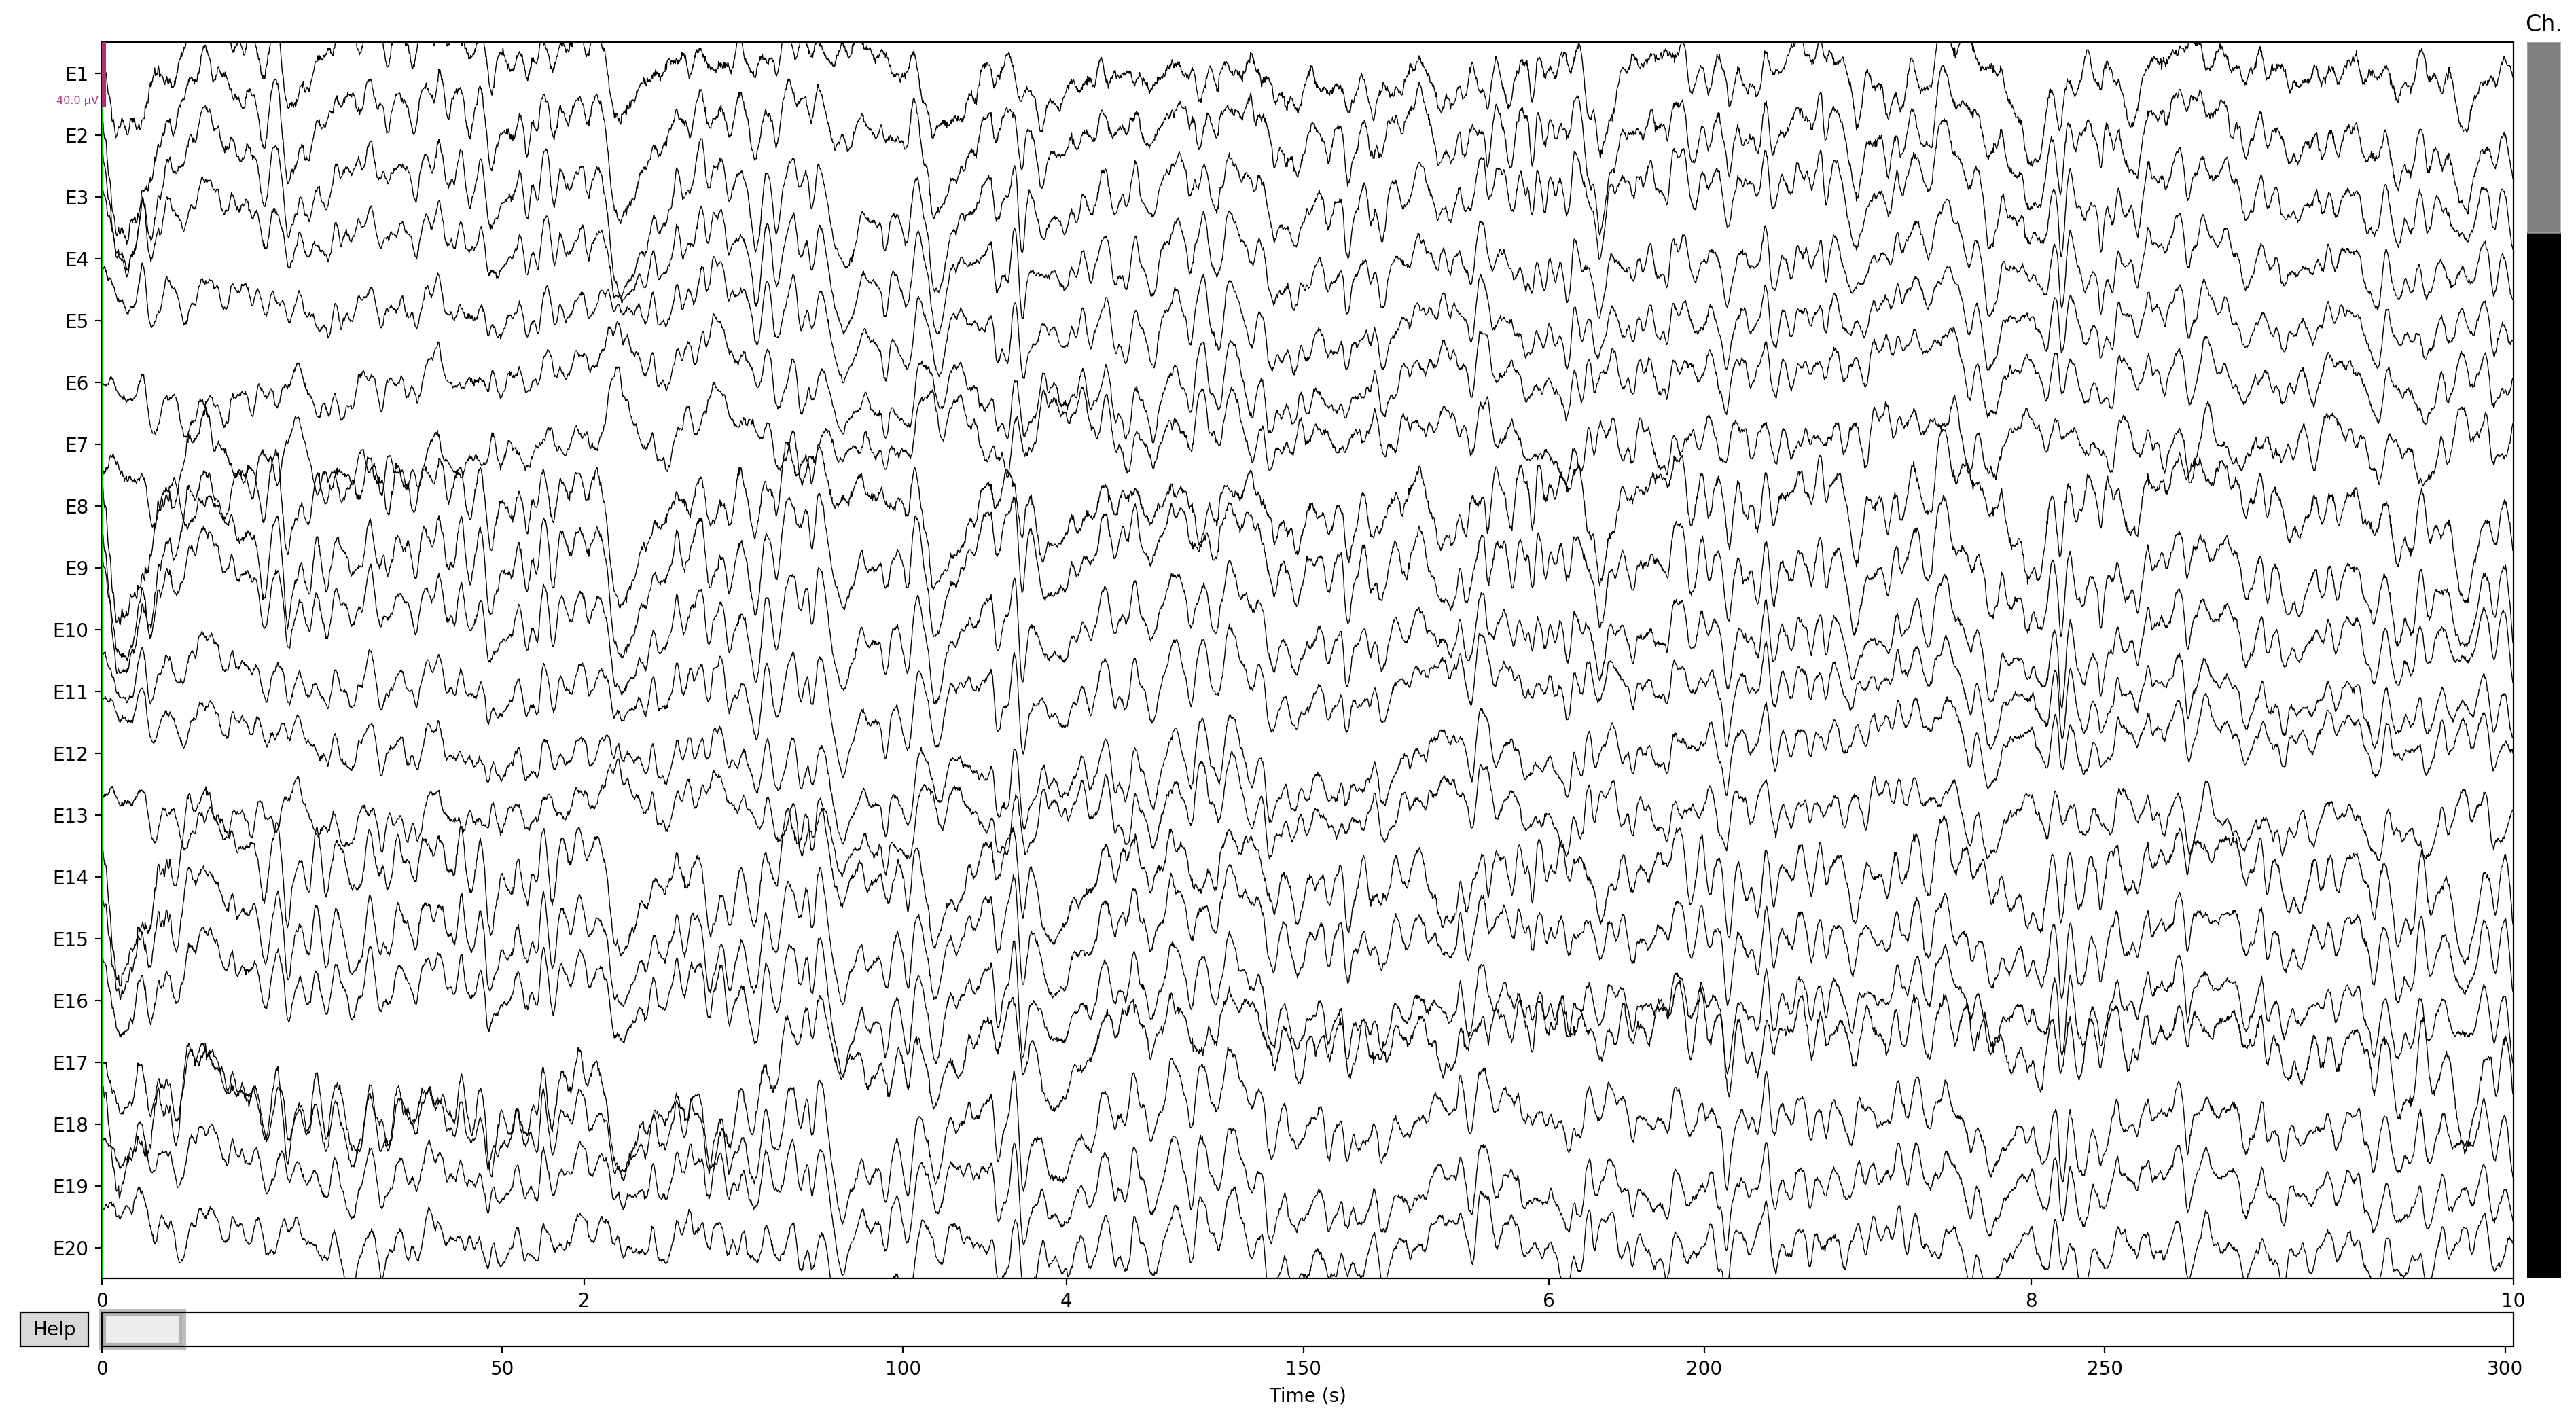

In [10]:
emerge5.plot()

Many different parameters can be chosen to format psd plot. Refer to this [tutorial](https://mne.tools/dev/auto_examples/time_frequency/plot_compute_raw_data_spectrum.html).

In [11]:
print(emerge5.plot_psd(average=True))

Effective window size : 4.096 (s)
Figure(1280x960)


Effective window size : 4.096 (s)
Figure(432x288)


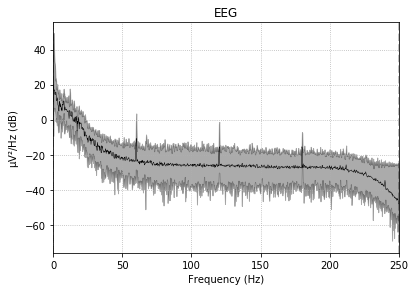

In [20]:
print(emerge5.plot_psd(area_mode='range', tmax=10.0, show=False, average=True)) # many different parameters are offered

## Segmentation

### Creating Epoched data from continuous data


If no experimental events are included in the recording (resting-state data for example), an event array of equally spaced events can be [generated](https://mne.tools/dev/generated/mne.make_fixed_length_events.html) . This is the case of this data. 
Refer to [this](https://mne.tools/stable/auto_tutorials/epochs/plot_10_epochs_overview.html#sphx-glr-auto-tutorials-epochs-plot-10-epochs-overview-py) when working with events.

In [21]:
new_events = mne.make_fixed_length_events(emerge5, start=5, stop=50, duration=2.5, overlap=0)

In [22]:
epochs = mne.Epochs(emerge5, new_events, tmin=-0.2, tmax=0.5, preload=True)

18 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 18 events and 351 original time points ...
0 bad epochs dropped


Plotting epochs as time series

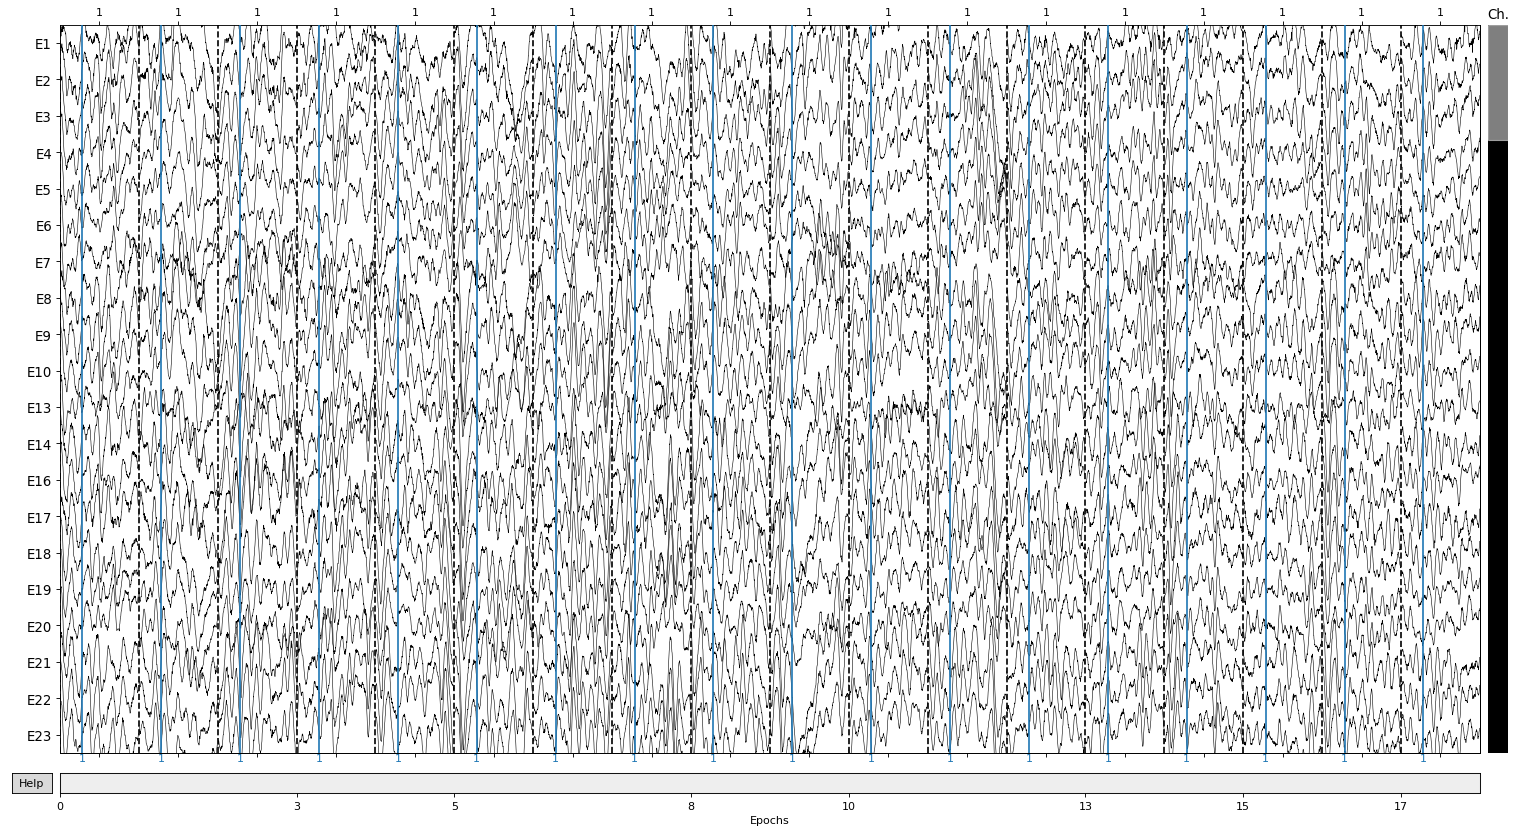

Figure(1536x824)


In [24]:
print(epochs.plot(events=new_events))

## Frequency analysis

### Plotting PSD

Plotting the power spectrum of Epochs. 

    Using multitaper spectrum estimation with 7 DPSS windows


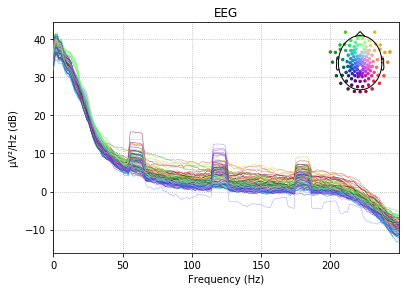

Figure(432x288)


In [26]:
print(epochs.plot_psd(picks='eeg'))

Plotting Epochs as an image map

18 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


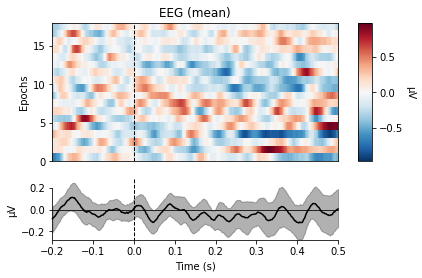

[<Figure size 432x288 with 3 Axes>]


In [27]:
print(epochs.plot_image(picks='eeg', combine='mean'))

[reference](https://mne.tools/stable/auto_tutorials/time-freq/plot_sensors_time_frequency.html#sphx-glr-auto-tutorials-time-freq-plot-sensors-time-frequency-py)

    Using multitaper spectrum estimation with 7 DPSS windows


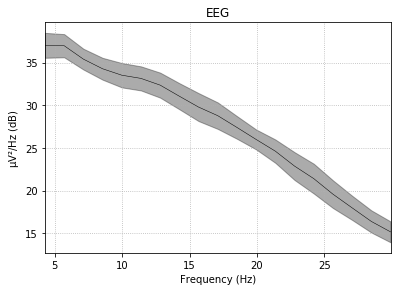

Figure(432x288)


In [37]:
#check out all channel types by averaging across epochs.
print(epochs.plot_psd(fmin=4., fmax=30., average=True))

Now let’s take a look at the spatial distributions of the PSD.

### Plotting via topomaps

    Using multitaper spectrum estimation with 7 DPSS windows


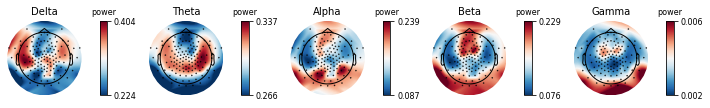

Figure(720x108)


In [29]:
print(epochs.plot_psd_topomap(ch_type='eeg', normalize=True))

Alternatively, you can also create PSDs from Epochs objects with functions that start with psd_ such as mne.time_frequency.psd_multitaper() and mne.time_frequency.psd_welch().
https://mne.tools/stable/auto_tutorials/time-freq/plot_sensors_time_frequency.html#sphx-glr-auto-tutorials-time-freq-plot-sensors-time-frequency-py


### Computing psd welch :  mne.time_frequency.psd_welch() 

Effective window size : 0.512 (s)
Effective window size : 0.512 (s)


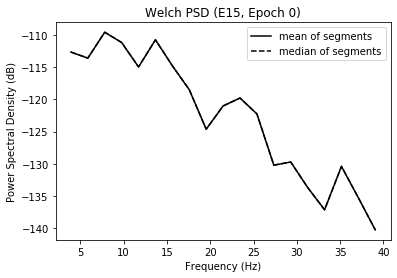

In [39]:
# Estimate PSDs based on "mean" and "median" averaging for comparison.
kwargs = dict(fmin=2, fmax=40, n_jobs=1)
psds_welch_mean, freqs_mean = psd_welch(epochs, average='mean', **kwargs)
psds_welch_median, freqs_median = psd_welch(epochs, average='median', **kwargs)

# Convert power to dB scale.
psds_welch_mean = 10 * np.log10(psds_welch_mean)
psds_welch_median = 10 * np.log10(psds_welch_median)

## We will only plot the PSD for a single sensor in the first epoch.
ch_name = 'E15'
ch_idx = epochs.info['ch_names'].index(ch_name)
epo_idx = 0

_, ax = plt.subplots()
ax.plot(freqs_mean, psds_welch_mean[epo_idx, ch_idx, :], color='k',
        ls='-', label='mean of segments')
ax.plot(freqs_median, psds_welch_median[epo_idx, ch_idx, :], color='k',
        ls='--', label='median of segments')

ax.set(title='Welch PSD ({}, Epoch {})'.format(ch_name, epo_idx),
       xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
ax.legend(loc='upper right')
plt.show()

## Conclusion

**MNE**: This brief overview of MNE for EEG data analysis was all based on this [documentation](https://mne.tools/stable/) available online. So many more [tutorials](https://mne.tools/stable/auto_tutorials/index.html) are offered on various subjects such as source modeling, statistical analysis of sensor data and source estimates, machine learning, simulation. MNE also offers sample datasets to practice with. 

**Github**: 
If you encounter any type of bug, have questions or want to deepen your understanding of MNE tools go checkout their [github page](https://github.com/mne-tools/mne-python). From there you can create [issues](https://docs.github.com/en/github/managing-your-work-on-github/about-issues) or consult previous discussions to resolve your problems. Responses come very fast and are definitely a great help !

First important thing to do before starting your [jupyter notebook](https://jupyter.org/) is to create a [github account](https://docs.github.com/en/github/getting-started-with-github).  GitHub is one of the biggest community of developers to discover, share, and build better software. It offers an open source version control system that helps manage and store revisions of projects, which is mandatory for quality coding. The other important thing is to subscribe to the [GitHub Student Developer Pack](https://education.github.com/) put in place to give students free access to the best developer tools in one place so they can learn by doing. 

**Python and more**:
Part of this package is some free access to programming classes such as python which will be of great help prior to starting with MNE (see [datacamp](https://www.datacamp.com/), [one month](https://onemonth.com/), and others). Additionally a great deal of python documentation is offered online (for free) and the community is very reponsive and helpful. Google a coding error and you'll see !

So many more tools are offered so go check it out. Don't hesitate to ask your questions via issues or enhance via pull requests on the Example-Analysis repository!